In [4]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [5]:
data = pd.read_csv("E:/Python/smsspamcollection.tsv", sep="\t")
data.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [6]:
data.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

In [7]:
# train_test split
df_ham = data[data.label == "ham"]
test_ham = df_ham.sample(frac = 0.2, random_state = 0)
print(test_ham.shape)
train_ham = df_ham.drop(test_ham.index)
print(train_ham.shape)

df_spam = data[data.label == "spam"]
test_spam = df_spam.sample(frac = 0.2, random_state = 0)
print(test_spam.shape)
train_spam = df_spam.drop(test_spam.index)
print(train_spam.shape)

(965, 4)
(3860, 4)
(149, 4)
(598, 4)


In [8]:
train_df = pd.concat((train_spam, train_ham))
print(train_df.shape)

test_df = pd.concat((test_spam, test_ham))
print(test_df.shape)

(4458, 4)
(1114, 4)


In [9]:
# text feature -> bag of word

# vocab = unique words
vocab = []

# using text processing: tokenization
for msg in train_df.message.values:
  for t in msg.lower().split():
    if t not in vocab:
      vocab.append(t)

In [10]:
# count vectorization
vocab_size = len(vocab)
word2idx = {t: i for i, t in enumerate(vocab)}
X_train = np.zeros((train_df.shape[0], vocab_size))

for i, msg in enumerate(train_df.message.values):
  for t in msg.lower().split():
    if t in vocab:
      X_train[i,word2idx[t]]+=1
X_train.shape

(4458, 11970)

In [11]:
X_test = np.zeros((test_df.shape[0], vocab_size))

for i, msg in enumerate(test_df.message.values):
  for t in msg.lower().split():
    if t in vocab:
      X_test[i,word2idx[t]]+=1
X_test.shape

(1114, 11970)

In [12]:
X_max = X_train.max(axis=0, keepdims=True)
X_min = X_train.min(axis=0, keepdims=True)
X_train_scaled = (X_train - X_min)/(X_max - X_min)
X_test_scaled = (X_test - X_min)/(X_max - X_min)

In [13]:
y_train = train_df.loc[:,["label"]].values
y_test = test_df.loc[:,["label"]].values
print(y_train.shape,y_test.shape)

(4458, 1) (1114, 1)


In [14]:
y_train_new = np.where(y_train == 'spam',0,1)
y_test_new = np.where(y_test == 'spam',0,1)
y_train_new

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [15]:
import numpy as np

class LogisticRegression1:
    def __init__(self, learning_rate=0.02, num_iterations=1000, fit_intercept=True):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.fit_intercept = fit_intercept
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # Khởi tạo các tham số
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iterations):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.learning_rate * gradient
            
            if(i % 10000 == 0):
                z = np.dot(X, self.theta)
                h = self.__sigmoid(z)
                print(f'loss: {self.__loss(h, y)} \t')
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X, threshold = 0.5):
        y_pred = self.predict_prob(X)
        y_pred[y_pred >=threshold] =1
        y_pred[y_pred <threshold] =0
        return y_pred

In [16]:
model = LogisticRegression1(fit_intercept=False)
model.fit(X_train_scaled, y_train_new[:,0])
y_hat = model.predict(X_test_scaled)

loss: 0.6929659429853519 	


## **Đánh giá mô hình: accuracy, recall, f1_score**

In [17]:
def evaluation(y_true, y_pred):
    # y_true và y_pred là hai danh sách chứa nhãn thực tế và nhãn dự đoán của các mẫu
    # Giả sử nhãn Positive là 1 và nhãn Negative là 0
    tp = tn = fp = fn = 0 # Khởi tạo các biến đếm
    for i in range(len(y_true)): # Duyệt qua từng cặp nhãn
        if y_true[i] == 1 and y_pred[i] == 1: # Nếu cả hai nhãn đều là Positive
            tp += 1 # Tăng biến tp lên 1
        elif y_true[i] == 0 and y_pred[i] == 0: # Nếu cả hai nhãn đều là Negative
            tn += 1 # Tăng biến tn lên 1
        elif y_true[i] == 0 and y_pred[i] == 1: # Nếu nhãn thực tế là Negative nhưng nhãn dự đoán lại là Positive
            fp += 1 # Tăng biến fp lên 1
        elif y_true[i] == 1 and y_pred[i] == 0: # Trường hợp còn lại, tức là nhãn thực tế là Positive nhưng nhãn dự đoán lại là Negative
            fn += 1 # Tăng biến fn lên 1
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1_score = 2*precision*recall/(precision+recall)
    print(f"Accuracy = {accuracy}")
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"F1 Score = {f1_score}")

In [18]:
evaluation(y_test_new, y_hat)

Accuracy = 0.9254937163375224
Precision = 0.9216061185468452
Recall = 0.9989637305699481
F1 Score = 0.9587270014917951


## **Khởi tạo hàm batch_generator để chia nhỏ dữ liệu khi train trên từng epochs**

In [19]:
import numpy as np

def batch_generator(X, y, batch_size):
    """
    Hàm chia dữ liệu thành các batch để train trên từng epoch
    
    Arguments:
    X -- ma trận đầu vào (m, n)
    y -- ma trận đầu ra (m, 1)
    batch_size -- kích thước mỗi batch
    
    Returns:
    batches -- list chứa các batch được chia từ dữ liệu đầu vào
    """
    
    m = X.shape[0]  # số lượng mẫu dữ liệu
    batches = []  # khởi tạo list chứa các batch
    
    # chia dữ liệu thành các batch
    for i in range(0, m, batch_size):
        X_batch = X[i:i+batch_size, :]
        y_batch = y[i:i+batch_size]
        batch = (X_batch, y_batch)
        batches.append(batch)
    
    return batches


## **Khởi tạo 1 class có tên là binary1, sử dụng các hàm ở trên và tích hợp trong class để huấn luyện mô hình. Đồng thời thêm hệ số bias. Đánh giá mô hình: accuracy, recall, f1_score**

In [20]:
# class binary1:
#     def __init__(self, learning_rate=0.1, n_iters=1000):
#         self.lr = learning_rate
#         self.n_iters = n_iters
#         self.weights = None
#         self.bias = None

#     def sigmoid(self, z):
#         return 1 / (1 + np.exp(-z))

#     def fit(self, X, y):
#         n_samples, n_features = X.shape

#         # init parameters
#         self.weights = np.zeros(n_features)
#         self.bias = 0

#         # gradient descent
#         for _ in range(self.n_iters):
#             linear_model = np.dot(X, self.weights) + self.bias
#             y_predicted = self.sigmoid(linear_model)

#             # compute gradients
#             dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
#             db = (1 / n_samples) * np.sum(y_predicted - y)

#             # update parameters
#             self.weights -= self.lr * dw
#             self.bias -= self.lr * db

#     def predict(self, X):
#         linear_model = np.dot(X, self.weights) + self.bias
#         y_predicted = self.sigmoid(linear_model)
#         y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
#         return y_predicted_cls

In [21]:
batch = batch_generator(X_train, y_train, 4458)
print(batch)

[(array([[1., 2., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]]), array([['spam'],
       ['spam'],
       ['spam'],
       ...,
       ['ham'],
       ['ham'],
       ['ham']], dtype=object))]


In [22]:
bias = np.ones((X_train.shape[0],1))
X_train_scaled = np.hstack((bias,X_train_scaled));

In [23]:
bias = np.ones((X_test.shape[0],1))
X_test_scaled = np.hstack((bias,X_test_scaled));

In [24]:
# sigmoid function
g = lambda z : np.exp(z) / (1+np.exp(z))

def predict_prob(X,w):
  z = np.dot(X,w)
  a = g(z)
  return a
def predict(X,w):
  y_hat = predict_prob(X,w)
  y_hat[y_hat >=0.5] =1
  y_hat[y_hat <0.5] =0
  return y_hat
# loss function
def loss(X,y,w):
  y_hat = predict_prob(X,w)
  l = y*np.log(y_hat) + (1-y)*np.log(1-y_hat)
  return -np.mean(l)

In [25]:
# gradient
def grad(X,y,w):
  y_hat = predict_prob(X,w)
  delta = y_hat - y
  dw = np.dot(X.T,delta)
  return dw

In [26]:
def gradient(X,y,lr = 1e-7, epochs = 2000):
  w = np.zeros((X.shape[1],1))
  losses = []
  for i in range(epochs):
    dw = grad(X,y,w)
    w -= lr*dw
    a = loss(X,y,w)
    losses.append(a)
  return losses,w

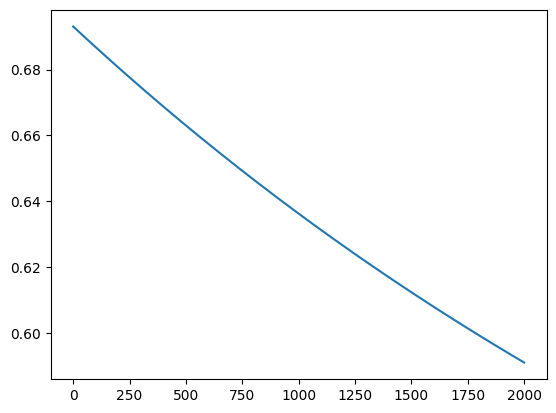

In [28]:
loss,w = gradient(X_train_scaled,y_train_new)
plt.plot(loss)

In [29]:
y_hat = predict(X_test_scaled,w)

In [30]:
# model = binary1()
# model.fit(X_train_scaled, y_train_new[:,0])
# y_hat = model.predict(X_test_scaled)
evaluation(y_test_new, y_hat)

Accuracy = 0.8662477558348295
Precision = 0.8662477558348295
Recall = 1.0
F1 Score = 0.9283309283309285
